In [1]:
#Fetch MNIST dataset
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
#look at arrays
X, y = mnist["data"], mnist["target"]
X.shape
#70,000 images, 784 features(28x28 pixels)

(70000, 784)

In [3]:
y.shape

(70000,)

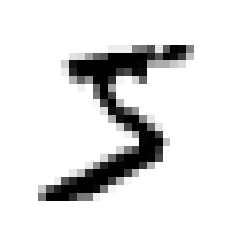

In [4]:
#View one digit from the dataset by getting feature vector and reshape to 28x28 array
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
#what is the data labeled as
y[0]

'5'

In [6]:
#the label is currently a string, cast y to an integer
y = y.astype(np.uint8)

In [7]:
#create test set. MNIST dataset is already split into training set (first 60,000 images) and test set (last 10,000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [8]:
#distinguish between 5 and not 5
y_train_5 = (y_train == 5) #true for all 5's, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
#create SGDClassifier and train it on the whole training set
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
#use classifier to detect images that are 5
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [11]:
#evaluate SGDClassifier model using K-fold cross-validation with three folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#very high accuracy, but accuracy is gernerally not the preferred performance measure for classifiers

array([0.95035, 0.96035, 0.9604 ])

In [12]:
#return predictions made on each test fold
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
#create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

#each row of confusion matrix represents an actual class, columns represent predicted class
#first row of matrix is non-5 images(negative class).
#TN|FP
#-----
#FN|TP

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
y_train_perfect_predictions = y_train_5 #pretend we reach perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In [15]:
#Precision measures accuracy of the postiive predictions
#Precision =
# TP
#------
#TP+FP

#Recall (AKA sensitivity or true positive rate) ratio of positive instances correctly detected by classifier
#Recall =
# TP
#------
#TP+FN

In [16]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) #when it claims image represents 5, how often is it correct?

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred) #how many 5's does it detect?

0.6511713705958311

In [18]:
#F1 score combines recall and precision into a single metric. Is simple way to compare two classifiers. It is
#harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
#increasing precision reduces recall and vice-versa

# Precision/Recall Trade-off

In [20]:
#decision_function returns a score for each instance, then use any threshold you want to make predictions based 
#on those scores
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
#threshold equal to 0 so will return same as predict() method (ie. True)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
#we then use any threshold you want to make predicitons based on scores
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
#results show that raising the threshold decreases recall. image actually represents 5, classifier detects it when 
#threshold is 0 but misses when threhold is increase to 8,000

array([False])

In [23]:
#Which threshold to use? Use cross_val_predict() to get all instances in training set and specify you want to return
#decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [24]:
#use above scores with precision_recall_curve() to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

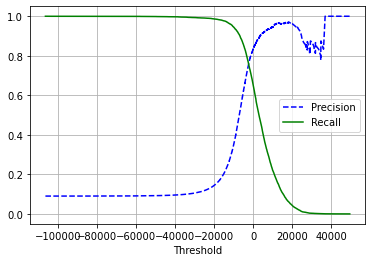

In [25]:
#plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.grid()
    plt.xlabel('Threshold')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

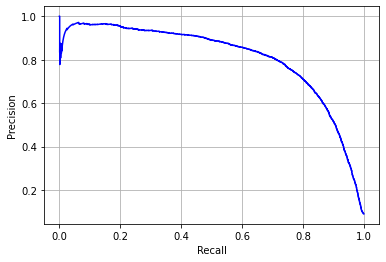

In [26]:
#Plot precision directly against recall to find a good precision/recall trade-off
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [27]:
#Plot shows the precision start to drop sharply at about %80 recall. Probably want to select precision/recall 
#trade-off just before drop

In [28]:
#to be more precise, search for lowest threshold that give you at least %90 precision. below method will give you
#first True value. 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

In [29]:
#make prediction on training set
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
#check predictions precision
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
#check predictions recall
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706